In [64]:
import os
import scipy.stats
import numpy as np
import matplotlib.ticker as ticker
import itertools
import matplotlib
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PathCollection
from collections import defaultdict

os.makedirs("plot", exist_ok=True)
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
sns.set_theme(rc={'figure.figsize':(12, 6)})

In [65]:
CHR_ORDER = [f"chr{i}" for i in itertools.chain(range(1, 23), ("X", "Y"))]
CHR_COLORS = [
  "#403E80",
  "#2C477D",
  "#2C477D",
  "#346B9B",
  "#3C80AA",
  "#4587A2",
  "#589D96",
  "#73ACA4",
  "#87BAAF",
  "#94BE9F",
  "#9FC38C",
  "#A1C27C",
  "#A4C165",
  "#C2C969",
  "#B5A957",
  "#DFD06C",
  "#F2D46C",
  "#E3C765",
  "#E5BA61",
  "#D89E56",
  "#C8824A",
  "#BB6B3E",
  "#AB5C40",
  "#9B4C41",
  "#8C3C42",
  "#731F37"
]
CHR_PALETTE = dict(zip(CHR_ORDER, CHR_COLORS))

In [66]:
cdr_bed = "data/hgsvc/all_cdrs.bed"
suppl_tsv = "data/hgsvc/supplementary.tsv"
lens_tsv = "data/hgsvc/all_AS-HOR_lengths.tsv"

In [67]:
df_suppl = pl.read_csv(suppl_tsv, separator="\t")
df_suppl

sample,ctg_name,total,correct,partial,incorrect,missed
str,str,i64,i64,i64,i64,i64
"""HG00512""","""haplotype1-0000018""",3,3,0,0,0
"""HG00731""","""haplotype1-0000003""",4,4,0,0,0
"""HG00731""","""haplotype1-0000004""",1,1,0,0,0
"""HG00731""","""haplotype1-0000006""",1,1,0,0,0
"""HG00731""","""haplotype1-0000008""",1,1,0,0,0
…,…,…,…,…,…,…
"""NA19434""","""haplotype1-0000039""",2,2,0,0,0
"""NA19434""","""haplotype1-0000049""",4,4,0,0,0
"""NA19434""","""haplotype2-0000127""",2,2,1,0,0


In [68]:
def extract_ctg_coords(df: pl.DataFrame) -> pl.DataFrame:
    return (
        df
        .lazy()
        .with_columns(split_name=pl.col("name").str.split_exact(by="_", n=2))
        .unnest("split_name")
        .rename({"field_0": "sample", "field_1": "chrom", "field_2": "ctg_name"})
        .with_columns(ctg_name=pl.col("ctg_name").str.split_exact(by=":", n=1))
        .unnest("ctg_name")
        .rename({"field_0": "ctg_name", "field_1": "ctg_coords"})
        .with_columns(ctg_coords=pl.col("ctg_coords").str.split_exact(by="-", n=1))
        .unnest("ctg_coords")
        .rename({"field_0": "ctg_st", "field_1": "ctg_end"})
        .cast({"ctg_st": pl.Int64, "ctg_end": pl.Int64})
        .with_columns(ctg_len=pl.col("ctg_end") - pl.col("ctg_st"))
        .collect()
    )

In [69]:
extract_ctg_coords(pl.read_csv(lens_tsv, new_columns=["name", "st", "end", "len"], separator="\t"))

name,st,end,len,sample,chrom,ctg_name,ctg_st,ctg_end,ctg_len
str,i64,i64,i64,str,str,str,i64,i64,i64
"""HG03520_chr1_haplotype2-000016…",121475383,125035199,3559816,"""HG03520""","""chr1""","""haplotype2-0000162""",120790444,125980692,5190248
"""HG00733_chr1_haplotype1-000002…",18126074,20181572,2055498,"""HG00733""","""chr1""","""haplotype1-0000023""",17409200,21180874,3771674
"""HG00171_rc-chr1_haplotype2-000…",121240405,125070851,3830446,"""HG00171""","""rc-chr1""","""haplotype2-0000151""",120517220,126081193,5563973
"""HG01573_rc-chr1_haplotype2-000…",121978753,126847451,4868698,"""HG01573""","""rc-chr1""","""haplotype2-0000081""",121293836,128226634,6932798
"""HG03248_chr1_haplotype2-000013…",121649856,127233626,5583770,"""HG03248""","""chr1""","""haplotype2-0000137""",120985620,128603118,7617498
…,…,…,…,…,…,…,…,…,…
"""NA19384_chrY_haplotype1-000000…",10357444,10628455,255205,"""NA19384""","""chrY""","""haplotype1-0000001""",9814035,11133536,1319501
"""HG00096_rc-chrY_haplotype1-000…",9875255,10199028,307962,"""HG00096""","""rc-chrY""","""haplotype1-0000033""",9332204,10704120,1371916
"""HG00358_rc-chrY_haplotype1-000…",10054993,11148695,1077895,"""HG00358""","""rc-chrY""","""haplotype1-0000017""",9511362,11653766,2142404


In [70]:
df_hor_lens = (
    extract_ctg_coords(pl.read_csv(lens_tsv, new_columns=["name", "st", "end", "len"], separator="\t"))
    .group_by(["name", "sample", "chrom", "ctg_name"])
    .agg(pl.col("st").min(), pl.col("end").max(), pl.col("len").sum())
    .join(df_suppl, on=["sample", "ctg_name"])
    .filter((pl.col("incorrect") == 0) & (pl.col("missed") == 0))
    .drop("total", "correct", "partial", "incorrect", "missed")
    .sort("name")
    .with_columns(pl.col("chrom").str.replace("rc-", ""))
)
df_hor_lens

name,sample,chrom,ctg_name,st,end,len
str,str,str,str,i64,i64,i64
"""HG00512_rc-chr16_haplotype1-00…","""HG00512""","""chr16""","""haplotype1-0000018""",18507386,20722483,2215097
"""HG00731_chr10_haplotype1-00000…","""HG00731""","""chr10""","""haplotype1-0000021""",39665015,41599215,1927592
"""HG00731_chr11_haplotype1-00000…","""HG00731""","""chr11""","""haplotype1-0000019""",50729381,53476899,2747518
"""HG00731_chr15_haplotype2-00000…","""HG00731""","""chr15""","""haplotype2-0000063""",7773424,8289884,516460
"""HG00731_chr17_haplotype2-00000…","""HG00731""","""chr17""","""haplotype2-0000048""",24082907,28534925,4452018
…,…,…,…,…,…,…
"""NA20509_rc-chr3_haplotype2-000…","""NA20509""","""chr3""","""haplotype2-0000105""",91698512,95634286,2612799
"""NA20509_rc-chr6_haplotype2-000…","""NA20509""","""chr6""","""haplotype2-0000099""",58615228,61671508,3056280
"""NA20509_rc-chr8_haplotype1-000…","""NA20509""","""chr8""","""haplotype1-0000011""",43792375,45269971,1477596


In [71]:
df_cdrs = (
    extract_ctg_coords(pl.read_csv(cdr_bed, new_columns=["name", "st", "end"], separator="\t"))
    .join(df_suppl, on=["sample", "ctg_name"])
    .filter((pl.col("incorrect") == 0) & (pl.col("missed") == 0))
    .with_columns(cdr_len=pl.col("end") - pl.col("st"))
    .drop("total", "correct", "partial", "incorrect", "missed")
    .sort("name")
    .with_columns(pl.col("chrom").str.replace("rc-", ""))
)
df_cdrs

name,st,end,sample,chrom,ctg_name,ctg_st,ctg_end,ctg_len,cdr_len
str,i64,i64,str,str,str,i64,i64,i64,i64
"""HG00512_rc-chr16_haplotype1-00…",18845325,18880325,"""HG00512""","""chr16""","""haplotype1-0000018""",17836728,21265325,3428597,35000
"""HG00512_rc-chr16_haplotype1-00…",18700325,18825325,"""HG00512""","""chr16""","""haplotype1-0000018""",17836728,21265325,3428597,125000
"""HG00512_rc-chr16_haplotype1-00…",18595325,18650325,"""HG00512""","""chr16""","""haplotype1-0000018""",17836728,21265325,3428597,55000
"""HG00731_chr10_haplotype1-00000…",39982778,40017778,"""HG00731""","""chr10""","""haplotype1-0000021""",38602778,42524971,3922193,35000
"""HG00731_chr10_haplotype1-00000…",40042778,40182778,"""HG00731""","""chr10""","""haplotype1-0000021""",38602778,42524971,3922193,140000
…,…,…,…,…,…,…,…,…,…
"""NA20509_rc-chr8_haplotype2-000…",45561548,45596548,"""NA20509""","""chr8""","""haplotype2-0000109""",42591949,46541548,3949599,35000
"""NA20509_rc-chr8_haplotype2-000…",45336548,45471548,"""NA20509""","""chr8""","""haplotype2-0000109""",42591949,46541548,3949599,135000
"""NA20509_rc-chr9_haplotype2-000…",45493488,45588488,"""NA20509""","""chr9""","""haplotype2-0000092""",44496087,47423488,2927401,95000


In [72]:
assert df_hor_lens["name"].unique().len() == df_cdrs["name"].unique().len()

In [73]:
df_final = (
    df_cdrs
    .join(df_hor_lens, on=["sample", "chrom", "ctg_name"])
    .drop(["name_right", "ctg_st_right", "ctg_end_right", "ctg_len_right"])
    .rename({"st_right": "hor_st", "end_right": "hor_end", "len": "hor_len"})
)
df_final

name,st,end,sample,chrom,ctg_name,ctg_st,ctg_end,ctg_len,cdr_len,hor_st,hor_end,hor_len
str,i64,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64
"""HG00512_rc-chr16_haplotype1-00…",18845325,18880325,"""HG00512""","""chr16""","""haplotype1-0000018""",17836728,21265325,3428597,35000,18507386,20722483,2215097
"""HG00512_rc-chr16_haplotype1-00…",18700325,18825325,"""HG00512""","""chr16""","""haplotype1-0000018""",17836728,21265325,3428597,125000,18507386,20722483,2215097
"""HG00512_rc-chr16_haplotype1-00…",18595325,18650325,"""HG00512""","""chr16""","""haplotype1-0000018""",17836728,21265325,3428597,55000,18507386,20722483,2215097
"""HG00731_chr10_haplotype1-00000…",39982778,40017778,"""HG00731""","""chr10""","""haplotype1-0000021""",38602778,42524971,3922193,35000,39665015,41599215,1927592
"""HG00731_chr10_haplotype1-00000…",40042778,40182778,"""HG00731""","""chr10""","""haplotype1-0000021""",38602778,42524971,3922193,140000,39665015,41599215,1927592
…,…,…,…,…,…,…,…,…,…,…,…,…
"""NA20509_rc-chr8_haplotype2-000…",45561548,45596548,"""NA20509""","""chr8""","""haplotype2-0000109""",42591949,46541548,3949599,35000,43485075,45815331,2330256
"""NA20509_rc-chr8_haplotype2-000…",45336548,45471548,"""NA20509""","""chr8""","""haplotype2-0000109""",42591949,46541548,3949599,135000,43485075,45815331,2330256
"""NA20509_rc-chr9_haplotype2-000…",45493488,45588488,"""NA20509""","""chr9""","""haplotype2-0000092""",44496087,47423488,2927401,95000,45010266,46918027,1907761


In [74]:
# ratio of cdr length / hor array length
# by chr
df_length_ratios = (
    df_final.group_by(["name"])
    .agg(
        pl.col("sample").first(),
        pl.col("chrom").first(),
        pl.col("cdr_len").sum(),
        pl.col("hor_len").first(),
        pl.col("ctg_len").first()
    )
    .with_columns(
        cdr_hor_arr_len_ratio=pl.col("cdr_len") / pl.col("hor_len"),
        cdr_ctg_len_ratio=pl.col("cdr_len") / pl.col("ctg_len")
    )
)
df_length_ratios

name,sample,chrom,cdr_len,hor_len,ctg_len,cdr_hor_arr_len_ratio,cdr_ctg_len_ratio
str,str,str,i64,i64,i64,f64,f64
"""HG03456_rc-chr10_haplotype2-00…","""HG03456""","""chr10""",220000,2124531,3966461,0.103552,0.055465
"""NA20509_rc-chr13_haplotype2-00…","""NA20509""","""chr13""",250000,1735867,4026042,0.14402,0.062096
"""HG03248_rc-chr22_haplotype2-00…","""HG03248""","""chr22""",175000,2288515,3385299,0.076469,0.051694
"""NA19317_rc-chr20_haplotype2-00…","""NA19317""","""chr20""",190000,3460486,5258278,0.054906,0.036134
"""NA20509_chr21_haplotype2-00000…","""NA20509""","""chr21""",130000,585235,1877663,0.222133,0.069235
…,…,…,…,…,…,…,…
"""NA20509_rc-chr9_haplotype2-000…","""NA20509""","""chr9""",190000,1907761,2927401,0.099593,0.064904
"""NA19434_rc-chr16_haplotype1-00…","""NA19434""","""chr16""",165000,1537427,2749549,0.107322,0.06001
"""HG03732_chr1_haplotype2-000007…","""HG03732""","""chr1""",260000,4288117,6260599,0.060633,0.04153


In [75]:
df_length_ratios.filter(pl.col("cdr_hor_arr_len_ratio") == pl.col("cdr_hor_arr_len_ratio").max())

name,sample,chrom,cdr_len,hor_len,ctg_len,cdr_hor_arr_len_ratio,cdr_ctg_len_ratio
str,str,str,i64,i64,i64,f64,f64
"""NA19650_chr21_haplotype1-00000…","""NA19650""","""chr21""",155000,241735,1630899,0.641198,0.09504


In [ ]:
largest_cdr_chr = df_length_ratios.filter(pl.col("cdr_len") == pl.col("cdr_len").max()).get_column("chrom").mode()[0]
smallest_cdr_chr = df_length_ratios.filter(pl.col("cdr_len") == pl.col("cdr_len").min()).get_column("chrom").mode()[0]
print(largest_cdr_chr)
print(smallest_cdr_chr)

chr19
chrY


In [97]:
df_length_ratios.filter(pl.col("cdr_len") == pl.col("cdr_len").max())

name,sample,chrom,cdr_len,hor_len,ctg_len,cdr_hor_arr_len_ratio,cdr_ctg_len_ratio
str,str,str,i64,i64,i64,f64,f64
"""NA19434_rc-chr19_haplotype1-00…","""NA19434""","""chr19""",375000,1852465,4747399,0.202433,0.078991


In [98]:
df_length_ratios.filter(pl.col("cdr_len") == pl.col("cdr_len").min())

name,sample,chrom,cdr_len,hor_len,ctg_len,cdr_hor_arr_len_ratio,cdr_ctg_len_ratio
str,str,str,i64,i64,i64,f64,f64
"""NA19384_chrY_haplotype1-000000…","""NA19384""","""chrY""",125000,255205,1319502,0.489802,0.094733
"""NA20509_chrY_haplotype1-000000…","""NA20509""","""chrY""",125000,360381,1424357,0.346855,0.087759
"""NA19650_chrY_haplotype1-000001…","""NA19650""","""chrY""",125000,365999,1430006,0.341531,0.087412


In [100]:
largest_cdrs_mean = round(df_length_ratios.filter(pl.col("chrom") == largest_cdr_chr).get_column("cdr_len").mean())
smallest_cdrs_mean = round(df_length_ratios.filter(pl.col("chrom") == smallest_cdr_chr).get_column("cdr_len").mean())
print(largest_cdrs_mean)
print(smallest_cdrs_mean)

298333
141667


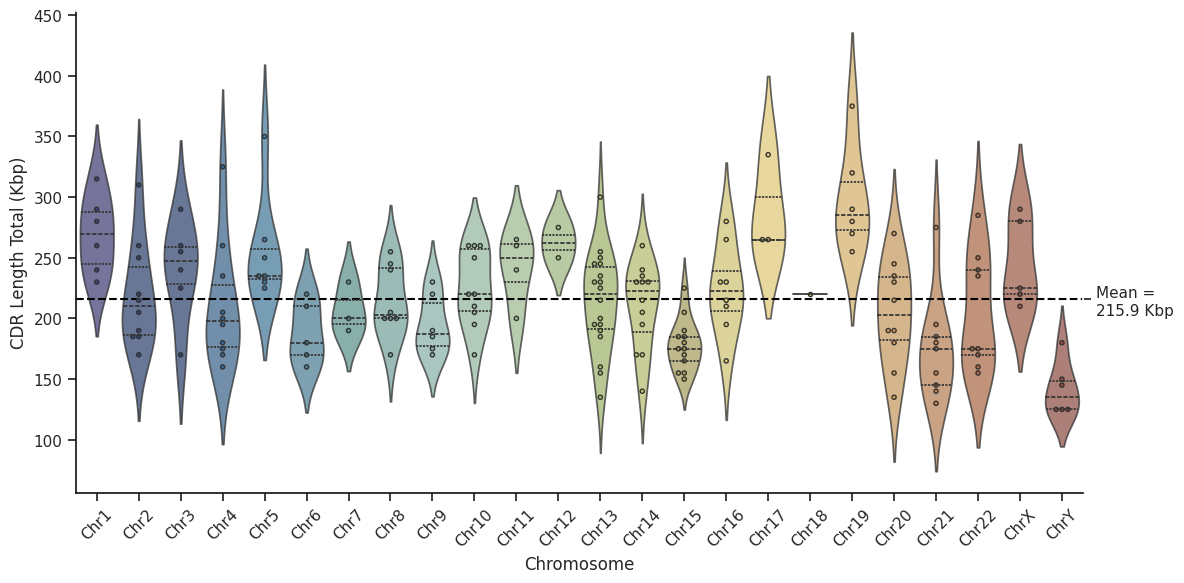

In [91]:
ax = sns.violinplot(
    data=df_length_ratios,
    x="chrom",
    y="cdr_len",
    hue="chrom",
    order=CHR_ORDER,
    inner="quart",
    palette=CHR_PALETTE,
)
plt.setp(ax.collections, alpha=.75)

# Set z-axis order so dots higher.
# https://stackoverflow.com/a/55801237
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

sns.swarmplot(
    x="chrom",
    y="cdr_len",
    data=df_length_ratios,
    size=3,
    ax=ax,
    hue="chrom",
    linewidth=1,
    order=CHR_ORDER,
    palette=CHR_PALETTE
)
# Round value to 2 digits
mean_cdr_len = round(df_length_ratios["cdr_len"].mean() / 1_000, 2) * 1_000
plt.axhline(y=mean_cdr_len, color="black", linestyle="--")
# Add ytick for mean cdr len
sec_ax = ax.secondary_yaxis("right")
sec_ax.set_yticks([mean_cdr_len])
sec_ax.set_yticklabels([f"Mean =\n{mean_cdr_len / 1_000} Kbp"])
# Rotate x
ax.tick_params(axis='x', rotation=45)
num_cens = df_length_ratios["name"].n_unique()
ax.set(xlabel="Chromosome", ylabel='CDR Length Total (Kbp)')

# Set x tick format
ax.set_xticks(range(len(CHR_ORDER)))
ax.set_xticklabels(f"C{c[1:]}" for c in CHR_ORDER)

# Set y tick format
ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y / 1_000) )
ax.yaxis.set_major_formatter(ticks_y)

# Remove grid
ax.grid(None)
ax.set_facecolor("white")
# Only show left and bottom spines.
ax.tick_params("both", left=True, bottom=True)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('k')

plt.tight_layout()
plt.savefig("plot/cdr_len.png", dpi=600)

/home/koisland/miniforge3/envs/jupyter/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10919: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/koisland/miniforge3/envs/jupyter/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10933: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/koisland/miniforge3/envs/jupyter/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10936: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


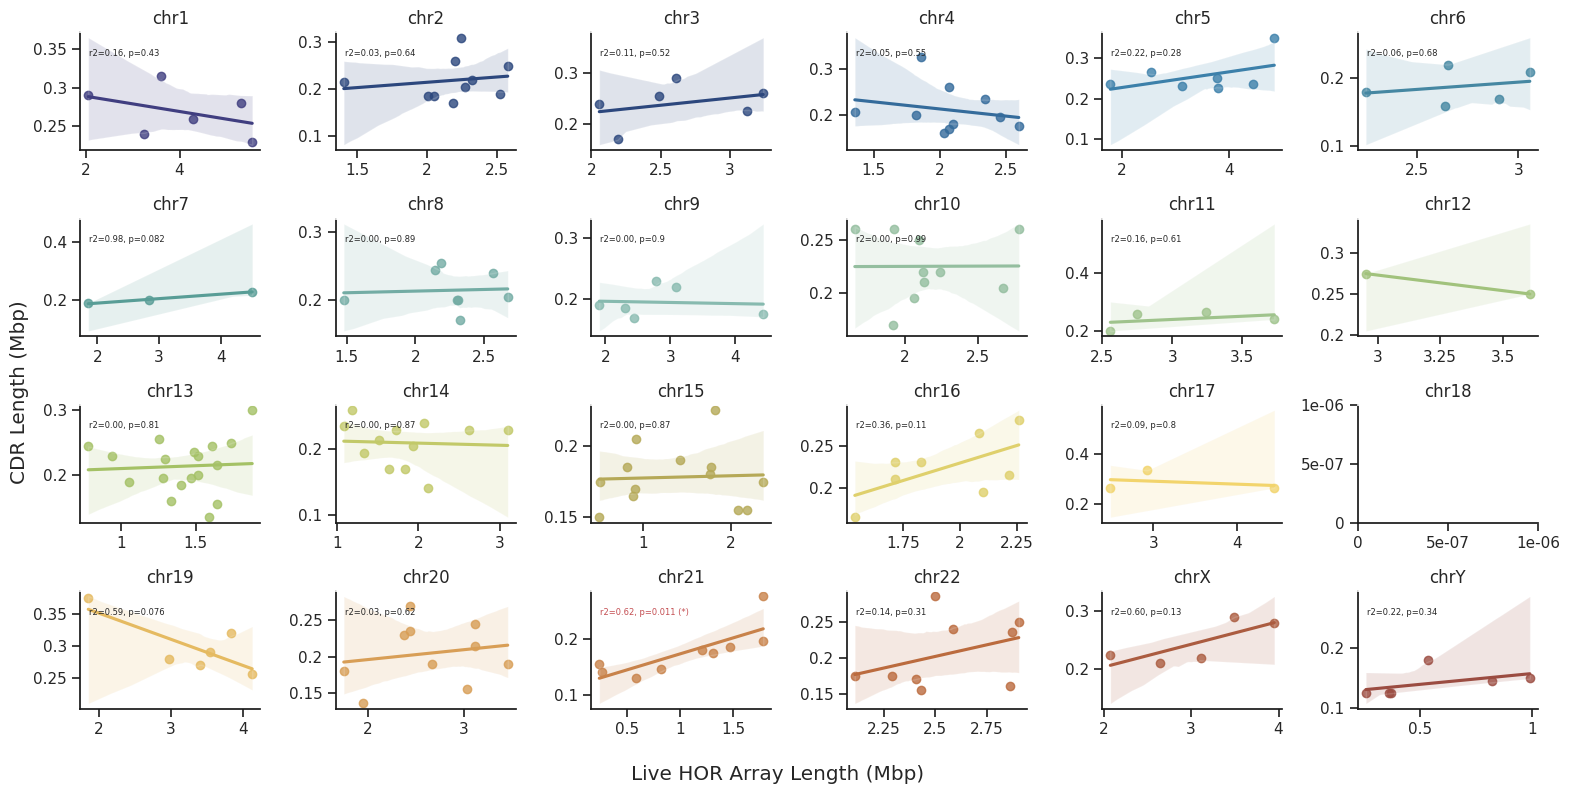

In [78]:
# https://stackoverflow.com/a/66325227
fig, axes = plt.subplots(4, 6, figsize=(16, 8))
for i, chrom in enumerate(CHR_ORDER):
    div, mod = divmod(i, 6)
    ax: plt.Axes = axes[div, mod]
    df_lens = df_length_ratios.filter(pl.col("chrom") == chrom)
    try:
        sns.regplot(df_lens, x="hor_len", y="cdr_len", color=CHR_COLORS[i], ax=ax)
    except TypeError:
        pass
    # Set tick interval.
    ax.set_title(chrom)
    
    # Set limits. y-lim set manually to fit data.
    ax.grid(None)
    ax.set_facecolor("white")
    # Draw spines of plot
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color('k')
    # Add ticks.
    ax.tick_params("both", left=True, bottom=True)

    # Set ticks to be in Mbp
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / 1_000_000))
    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y / 1_000_000))
    ax.xaxis.set_major_formatter(ticks_x)
    ax.yaxis.set_major_formatter(ticks_y)

    # Calculate linear regression and p-value
    res = scipy.stats.linregress(df_lens['hor_len'], df_lens['cdr_len'])
    if res.pvalue == 0.0 or np.isnan(res.pvalue):
        continue

    # If significant, color red.
    fontdict=dict(transform=ax.transAxes, fontsize=6)
    if res.pvalue < 0.05:
        txt = 'r2={:.2f}, p={:.2g} (*)'.format(res.rvalue**2, res.pvalue)
        fontdict["color"] = "r"
    else:
        txt = 'r2={:.2f}, p={:.2g}'.format(res.rvalue**2, res.pvalue)

    ax.text(.05, .8, txt, **fontdict)

# fig.suptitle("Relative CDR Position by Chromosome")
fig.supxlabel("Live HOR Array Length (Mbp)")
fig.supylabel("CDR Length (Mbp)")
fig.set_tight_layout(True)
plt.savefig("plot/arr_len_cdr_linregress.png", dpi=600)

In [79]:
# # Also show lengths.
# chrom_palette = dict(zip(CHR_ORDER, CHR_COLORS))

# ax = sns.violinplot(
#     data=df_length_ratios,
#     x="chrom",
#     y="cdr_hor_arr_len_ratio",
#     hue="chrom",
#     order=CHR_ORDER,
#     palette=chrom_palette,
# )
# plt.setp(ax.collections, alpha=.75)

# # Set z-axis order so dots higher.
# # https://stackoverflow.com/a/55801237
# for artist in ax.lines:
#     artist.set_zorder(10)
# for artist in ax.findobj(PathCollection):
#     artist.set_zorder(11)

# sns.stripplot(
#     x="chrom",
#     y="cdr_hor_arr_len_ratio",
#     data=df_length_ratios,
#     jitter=0.2,
#     ax=ax,
#     hue="chrom",
#     linewidth=1,
#     order=CHR_ORDER,
#     palette=chrom_palette
# )
# ax.tick_params(axis='x', rotation=45)
# num_cens = df_length_ratios["name"].n_unique()
# # ax.set_title(f"CDR to Live HOR Array Length by Chromosome")
# ax.set(xlabel="Chromosome", ylabel='Length of CDR : Length of live HOR array')

# ax.grid(None)
# ax.set_facecolor("white")
# ax.tick_params("both", left=True, bottom=True)
# for spine in ['left', 'bottom']:
#     ax.spines[spine].set_color('k')
# plt.tight_layout()
# plt.savefig("plot/cdr_hor_arr_len.png", dpi=600)

In [80]:
# # Also show lengths.
# ax = sns.violinplot(
#     data=df_hor_lens,
#     x="chrom",
#     y="len",
#     hue="chrom",
#     order=CHR_ORDER,
#     palette=CHR_PALETTE,
# )
# plt.setp(ax.collections, alpha=.75)

# # Set z-axis order so dots higher.
# # https://stackoverflow.com/a/55801237
# for artist in ax.lines:
#     artist.set_zorder(10)
# for artist in ax.findobj(PathCollection):
#     artist.set_zorder(11)

# sns.stripplot(
#     x="chrom",
#     y="len",
#     data=df_hor_lens,
#     jitter=0.2,
#     ax=ax,
#     hue="chrom",
#     linewidth=1,
#     order=CHR_ORDER,
#     palette=chrom_palette
# )
# ax.tick_params(axis='x', rotation=45)
# num_cens = df_length_ratios["name"].n_unique()
# # ax.set_title(f"Live HOR Array Length by Chromosome")
# ax.set(xlabel="Chromosome", ylabel='Live HOR Array Length (Mbp)')

# ax.grid(None)
# ax.set_facecolor("white")
# ax.tick_params("both", left=True, bottom=True)
# for spine in ['left', 'bottom']:
#     ax.spines[spine].set_color('k')
# plt.tight_layout()
# plt.savefig("plot/hor_arr_len.png", dpi=600)

In [81]:
# relative position of cdr
# by chr
df_rel_pos = (
    df_final.select("name", "chrom", "sample", "ctg_name", "st", "end", "hor_st", "hor_end")
    .with_columns(arr_len=pl.col("hor_end") - pl.col("hor_st"))
    .with_columns(
        st_rel=(((pl.col("st") - pl.col("hor_st")) / pl.col("arr_len")) * 100).round().cast(pl.Int8),
        end_rel=(((pl.col("end") - pl.col("hor_st")) / pl.col("arr_len")) * 100).round().cast(pl.Int8),
    )
    .select("chrom", "st_rel", "end_rel")
)
df_rel_pos

chrom,st_rel,end_rel
str,i8,i8
"""chr16""",15,17
"""chr16""",9,14
"""chr16""",4,6
"""chr10""",16,18
"""chr10""",20,27
…,…,…
"""chr8""",89,91
"""chr8""",79,85
"""chr9""",25,30


In [82]:
positions = defaultdict(list)
for chrom, df_grp in df_rel_pos.group_by(["chrom"]):
    chrom = chrom[0]
    # Small enough range that this is acceptable.
    for _, st, end in df_grp.iter_rows():
        positions[chrom].extend(range(st, end+1))

In [83]:
df_chr_relpos = pl.DataFrame(
    ((chrom, pos)
    for chrom, pos_cnts in positions.items()
    for pos in pos_cnts),
    orient="row",
    schema=["chrom", "pos"]
)
df_chr_relpos

chrom,pos
str,i64
"""chr4""",43
"""chr4""",44
"""chr4""",45
"""chr4""",46
"""chr4""",47
…,…
"""chr8""",81
"""chr8""",82
"""chr8""",83


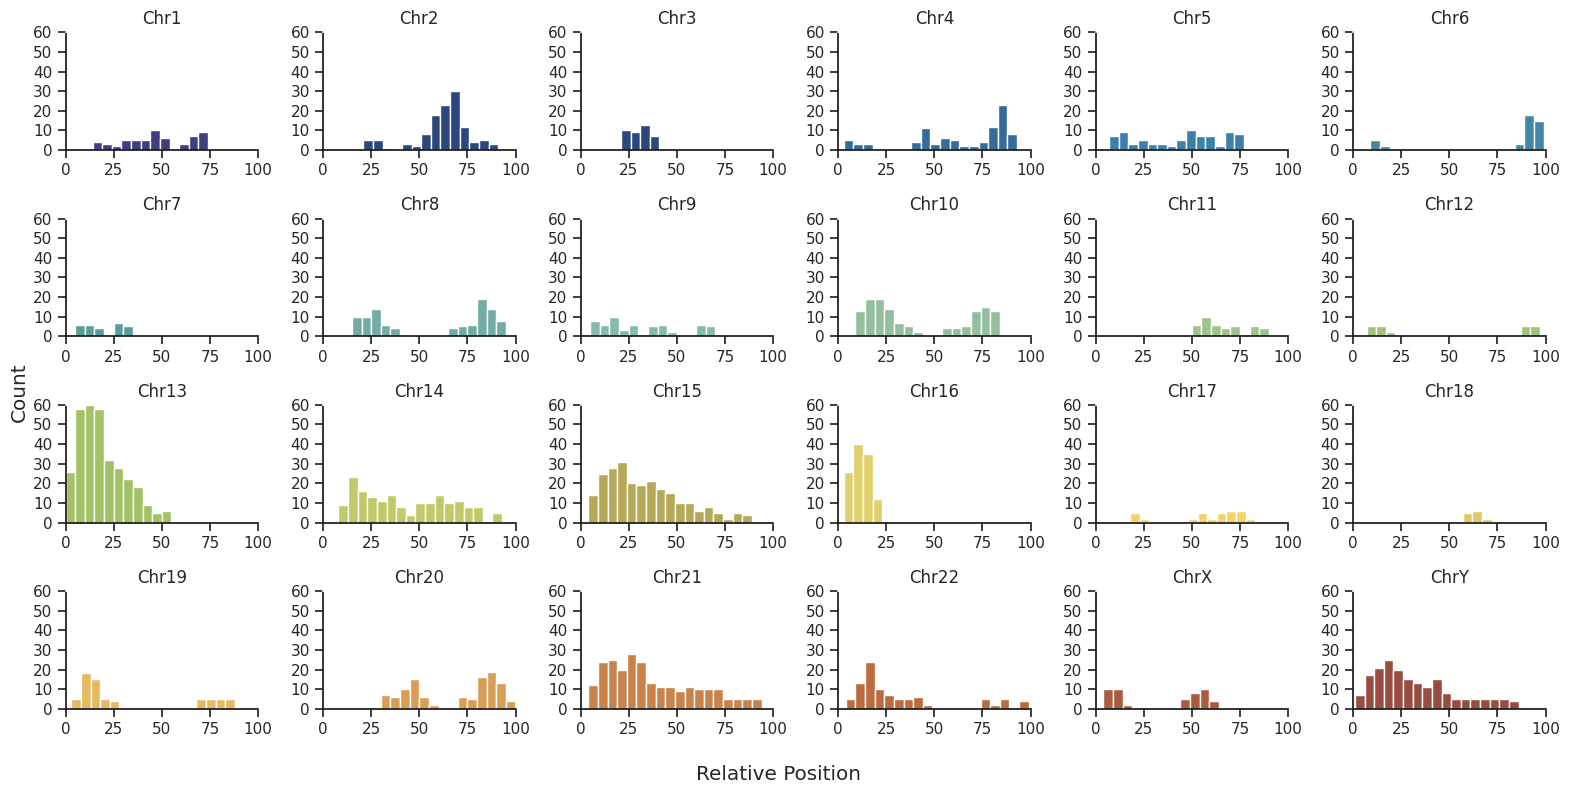

In [92]:
# Try to make similar # of tick marks on both axes.
# Show cdr and hor tracks alongside clustering.

fig, axes = plt.subplots(4, 6, figsize=(16, 8))
for i, chrom in enumerate(CHR_ORDER):
    div, mod = divmod(i, 6)
    ax: plt.Axes = axes[div, mod]
    positions = df_chr_relpos.filter(pl.col("chrom") == chrom).get_column("pos")
    ax.hist(positions, np.arange(min(positions), max(positions) + 5, 5), color=CHR_COLORS[i])
    
    # Set tick interval.
    ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.set_title(f"C{chrom[1:]}")
    
    # Set limits. y-lim set manually to fit data.
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 60)
    ax.grid(None)
    ax.set_facecolor("white")
    # Draw spines of plot
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color('k')
    # Add ticks.
    ax.tick_params("both", left=True, bottom=True)

# fig.suptitle("Relative CDR Position by Chromosome")
fig.supxlabel("Relative Position")
fig.supylabel("Count")
fig.set_tight_layout(True)
fig.savefig("plot/rel_cdr_pos.png", dpi=600)